In [64]:
import pandas as pd
import numpy as np
import networkx as nx
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from operator import itemgetter
from tqdm import tqdm
from itertools import combinations

sns.set_style("whitegrid")
sns.set_context("talk")


warnings.filterwarnings("ignore")

In [131]:
print(scipy.__version__)

1.7.3


In [2]:
df_edges = pd.read_csv("edges_similarity_update.csv")
df_edges.sample(5)

,Unnamed: 0,source,target,title_topic,topic_title,weight,same_level,importance,topic_section,similarity,section_title,title_section,section_topic,options,is_child_of,is_parent_of
230103,230103,методы цифровой обработки сигналов (цос),транзисторные усилители,0,0,3,0,0.909,0,0.303,0,0,0,0,0,0
122371,122371,технологии анализа данных,инженерия знаний,0,0,1,0,0.490,0,0.490,0,0,0,0,0,0
34390,34390,линейные операторы,школьная математика,0,0,2,0,0.894,0,0.447,0,0,0,0,0,0
158976,158976,теплопроводность,постоянное магнитное поле,0,0,1,0,0.344,0,0.344,0,0,0,0,0,0
146188,146188,интегральное исчисление,методы агентного моделирования,0,0,4,0,0.828,0,0.207,0,0,0,0,0,0


In [8]:
df_edges.shape

(264642, 16)

In [3]:
df_edges[["same_level", "is_child_of", "is_parent_of"]].astype(bool).sum(axis=0)

same_level      31136
is_child_of     35203
is_parent_of    39576
dtype: int64

In [5]:
items = pd.read_csv("cleaner_items_and_duplicates.csv")
items.head()

,id,name,lowercase,no_punkt,translated,spellchecked,lemmas,len_trans,has_abbr,dups,dups_n
0,26876,Основные микробиологические методы исследования,основные микробиологические методы исследования,основные микробиологические методы исследования,основные микробиологические методы исследования,основные микробиологические методы исследования,"('основной', 'микробиологический', 'метод', 'и...",4,False,[],0
1,15,Геометрия,геометрия,геометрия,геометрия,геометрия,"('геометрия',)",1,False,"[(15, 'Геометрия'), (19750, 'Geometry'), (2272...",3
2,148,Обходы графов,обходы графов,обходы графов,обходы графов,обходы графов,"('обход', 'граф')",2,False,"[(148, 'Обходы графов'), (19996, 'Обходы графо...",2
3,245,Метод Гаусса,метод гаусса,метод гаусса,метод гаусса,метод гаусса,"('метод', 'гаусс')",2,False,"[(245, 'Метод Гаусса'), (1874, 'Методы Гаусса')]",2
4,115,Корреляция,корреляция,корреляция,корреляция,корреляция,"('корреляция',)",1,False,"[(115, 'Корреляция'), (19845, 'Correlation')]",2


In [6]:
all_items = set(df_edges.source.tolist()) | set(df_edges.target.tolist())
dups = set(items.lowercase.tolist())

print(len(all_items), len(dups))

16287 18749


In [13]:
len(all_items-dups)

2258

В данных для построения графа 2258 некорректных сущностей или сущностей-дубликатов.

In [14]:
oriented_edges = set()
for i in df_edges.index.values:
    if (df_edges["is_parent_of"][i] >= 
        df_edges["is_child_of"][i]) and sum((df_edges["is_parent_of"][i],
                                                df_edges["is_child_of"][i]))>0:   # если чаще родитель или одинаково в обе стороны иерархии
        oriented_edges.add((df_edges["source"][i], df_edges["target"][i], df_edges["weight"][i]))
    elif df_edges["is_parent_of"][i] < df_edges["is_child_of"][i]:
        oriented_edges.add((df_edges["target"][i], df_edges["source"][i], df_edges["weight"][i]))
    elif df_edges["same_level"][i] > 0 or df_edges["options"][i] == 0:
        oriented_edges.add((df_edges["target"][i], df_edges["source"][i], df_edges["weight"][i]))
        oriented_edges.add((df_edges["source"][i], df_edges["target"][i], df_edges["weight"][i]))


In [15]:
OG = nx.DiGraph()
OG.add_weighted_edges_from(oriented_edges)
print(OG)

DiGraph with 16287 nodes and 465228 edges


In [5]:
gm = nx.google_matrix(OG)

In [6]:
gm.shape

(11992, 11992)

In [7]:
moral = nx.moral_graph(OG)  # моральный граф

In [8]:
print(moral)

Graph with 11992 nodes and 664574 edges


In [16]:
degree_dict = dict(OG.degree(OG.nodes()))
nx.set_node_attributes(OG, degree_dict, 'degree')
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
print("Top 15 nodes by degree:")
sorted_degree[:15]

Top 15 nodes by degree:


[('программное обеспечение', 2352),
 ('системы управления', 2307),
 ('технологический процесс', 2097),
 ('информационная система', 1998),
 ('машинное обучение', 1938),
 ('практические навыки', 1882),
 ('принципы построения сапр', 1881),
 ('жизненный цикл', 1800),
 ('методы исследования', 1710),
 ('анализ данных', 1688),
 ('математическое моделирование', 1623),
 ('базы данных', 1513),
 ('языки программирования', 1507),
 ('математическая модель', 1351),
 ('профессиональная деятельность эколога', 1249)]

In [17]:
deg_df = pd.DataFrame(sorted_degree, columns=["entity", "degree"])
deg_df.head()

,entity,degree
0,программное обеспечение,2352
1,системы управления,2307
2,технологический процесс,2097
3,информационная система,1998
4,машинное обучение,1938


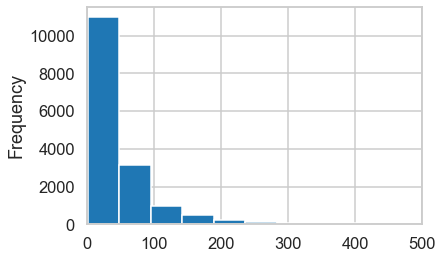

In [24]:
deg_df.degree.plot(kind="hist", bins=50, xlim=(0,500));

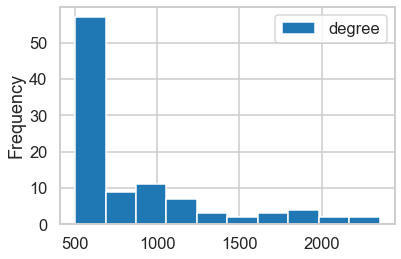

In [30]:
deg_df.query("degree > 500").plot(kind="hist", bins=10);

In [31]:
clust = nx.average_clustering(OG)
clust

0.640074743633228

In [34]:
nd = sorted(nx.average_neighbor_degree(OG).items(), key=itemgetter(1), reverse=True)  # что-то интересное, надо покопать под результаты
nd[:15]

[('биометрические системы аутентификации', 715.0),
 ('моделирование объектов контроля и процедур измерения', 665.5),
 ('градиентные системы мр-томографов', 655.0),
 ('ситуационное руководство', 638.5),
 ('биогеография', 638.0),
 ('автоматизированный расчет теплофизических и транспортных свойств криогенных газов и смесей',
  620.5),
 ('создание встраиваемых приложений на базе программируемых логических интегральных схем – плис',
  583.5),
 ('клеточная биотехнология', 578.0),
 ('процесс старения', 555.0),
 ('интерфейсы встроенных систем', 537.2),
 ('программируемые логические интегральные схемы (плис)', 525.5),
 ('приборы для инструментальных обследований', 515.75),
 ('принципы здорового питания', 484.0),
 ('дата-история', 477.0),
 ('геометрия', 475.5)]

In [37]:
# топ вершин по степени
sorted_degree = sorted(nx.degree_centrality(OG).items(), key=itemgetter(1), reverse=True)
print("Top 15 nodes by degree:")
sorted_degree[:15]

Top 15 nodes by degree:


[('программное обеспечение', 0.14441851897335134),
 ('системы управления', 0.14165540955421835),
 ('технологический процесс', 0.12876089893159767),
 ('информационная система', 0.12268205820950509),
 ('машинное обучение', 0.11899791231732776),
 ('практические навыки', 0.11555937615129558),
 ('принципы построения сапр', 0.1154979737197593),
 ('жизненный цикл', 0.1105243767653199),
 ('методы исследования', 0.1049981579270539),
 ('анализ данных', 0.10364730443325555),
 ('математическое моделирование', 0.09965614638339677),
 ('базы данных', 0.092901878914405),
 ('языки программирования', 0.09253346432518728),
 ('математическая модель', 0.08295468500552622),
 ('профессиональная деятельность эколога', 0.07669163698882475)]

In [38]:
# топ вершин по полустепени захода
sorted_indegree = sorted(nx.in_degree_centrality(OG).items(), key=itemgetter(1), reverse=True)
print("Top 15 nodes by in degree:")
sorted_indegree[:15]

Top 15 nodes by in degree:


[('программное обеспечение', 0.06748127225838142),
 ('системы управления', 0.0665602357853371),
 ('технологический процесс', 0.06330590691391379),
 ('принципы построения сапр', 0.05894633427483728),
 ('практические навыки', 0.058639322117155834),
 ('жизненный цикл', 0.05667444430799459),
 ('машинное обучение', 0.05403413975193417),
 ('информационная система', 0.05397273732039788),
 ('методы исследования', 0.04973596954439395),
 ('анализ данных', 0.0472798722829424),
 ('математическое моделирование', 0.04648164067297065),
 ('языки программирования', 0.04629743337836178),
 ('базы данных', 0.04249048262311187),
 ('математическая модель', 0.04249048262311187),
 ('окружающая среда', 0.0373940808055999)]

In [73]:
# топ вершин по полустепени исхода
sorted_outdegree = sorted(nx.out_degree_centrality(OG).items(), key=itemgetter(1), reverse=True)
print("Top 15 nodes by out degree:")
sorted_outdegree[:15]

Top 15 nodes by out degree:


[('программное обеспечение', 0.0769372467149699),
 ('системы управления', 0.07509517376888124),
 ('информационная система', 0.06870932088910721),
 ('технологический процесс', 0.0654549920176839),
 ('машинное обучение', 0.06496377256539358),
 ('практические навыки', 0.056920054034139744),
 ('принципы построения сапр', 0.05655163944492202),
 ('анализ данных', 0.056367432150313146),
 ('методы исследования', 0.05526218838265995),
 ('жизненный цикл', 0.053849932457325306),
 ('математическое моделирование', 0.05317450571042613),
 ('базы данных', 0.05041139629129313),
 ('языки программирования', 0.04623603094682549),
 ('профессиональная деятельность эколога', 0.04077121454009579),
 ('математическая модель', 0.04046420238241434)]

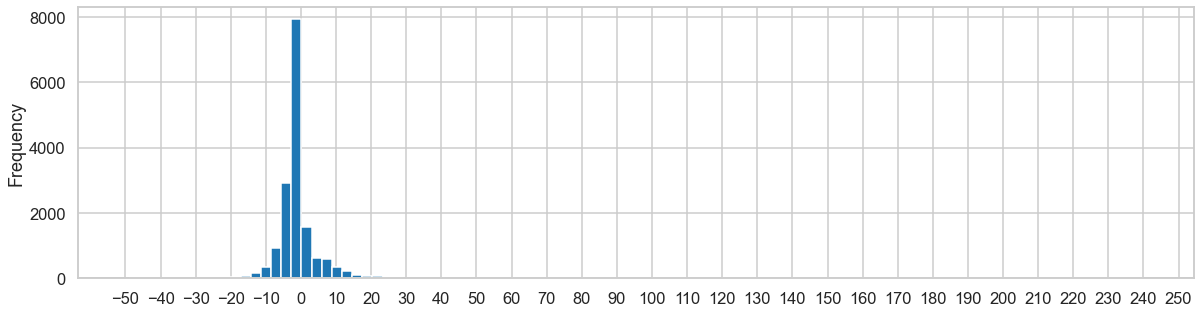

In [58]:
# распределение разности между полустепенью исхода и захода у вершин
out_degree_dict = dict(OG.out_degree(OG.nodes()))
in_degree_dict = dict(OG.in_degree(OG.nodes()))
out_deg_df = pd.DataFrame(out_degree_dict.items(), columns=["entity", "out_degree"])
in_deg_df = pd.DataFrame(in_degree_dict.items(), columns=["entity", "in_degree"])
deg_df = pd.merge(out_deg_df, in_deg_df, left_on="entity", right_on="entity")
deg_df["delta"] = deg_df["out_degree"]-deg_df["in_degree"]
deg_df.delta.plot(kind="hist", bins=100, figsize=(20,5), xticks=range(-50,255,10));

Вершины, у которых полустепень исхода сильно выше полустепени захода, то есть это топовый уровень иерархии.

In [59]:
deg_df.query("delta>=100").sort_values(by="delta", ascending=False)

,entity,out_degree,in_degree,delta
380,информационная система,1119,879,240
1980,информационная безопасность,620,431,189
394,машинное обучение,1058,880,178
51,программное обеспечение,1253,1099,154
116,анализ данных,918,770,148
1295,системы управления,1223,1084,139
306,базы данных,821,692,129
113,продукты питания,324,200,124
618,искусственный интеллект,646,522,124
550,математическое моделирование,866,757,109


In [61]:
deg_df["part"] = (deg_df.out_degree / deg_df.in_degree).round(2)
deg_df.query("part > 1 & in_degree > 0").sort_values(by="part", ascending=False)

,entity,out_degree,in_degree,delta,part
4857,прикладная биотехнология,26,1,25,26.00
14893,вычислительное музыковедение,17,1,16,17.00
5274,проектирование автоматизированных систем,14,1,13,14.00
13864,основы технического регулирования и стандартиз...,14,1,13,14.00
15709,телефонная сеть общего пользования,14,1,13,14.00
...,...,...,...,...,...
4008,логическое проектирование бд,90,89,1,1.01
855,работа с библиотекой pandas,93,92,1,1.01
3745,организация грид-систем,156,155,1,1.01
6906,явление переноса,68,67,1,1.01


In [63]:
deg_df.query("part > 10 & in_degree > 0").sort_values(by="part", ascending=False)

,entity,out_degree,in_degree,delta,part
4857,прикладная биотехнология,26,1,25,26.0
14893,вычислительное музыковедение,17,1,16,17.0
15709,телефонная сеть общего пользования,14,1,13,14.0
5274,проектирование автоматизированных систем,14,1,13,14.0
13864,основы технического регулирования и стандартиз...,14,1,13,14.0
9393,надежность систем с многопутевой марщрутизацией,14,1,13,14.0
2309,юстировка оптических приборов,14,1,13,14.0
11140,общестроительное проектирование предприятий мо...,13,1,12,13.0
9095,cancer stem cells,13,1,12,13.0
13254,техническая электродинамика,25,2,23,12.5


In [87]:
e1_e2 = {("машинное обучение", vertice) for vertice in nx.descendants_at_distance(OG, source="машинное обучение", distance=1)}
e2_e3 = set(combinations(nx.descendants_at_distance(OG, source="машинное обучение", distance=1), 2))

In [65]:
DG = OG.copy()

In [66]:
for e1 in tqdm(DG.nodes):
    descendants = nx.descendants_at_distance(DG, source=e1, distance=1)
    e1_e2 = {(e1, vertice) for vertice in descendants}
    e2_e3 = set(combinations(descendants, 2))
    same_level = set()
    hierarchy = set()
    weights = nx.get_edge_attributes(DG, "weight")

    for edge in e2_e3:
        e2, e3 = edge
        if (e2, e3) in DG.edges and (e3, e2) in DG.edges:
            same_level.add((e2, e3))
            same_level.add((e3, e2))
        elif (e2, e3) in DG.edges:
            if (weights[(e2,e3)] > weights[(e1,e3)] or weights[(e2,e3)] == weights[(e1,e3)] > 1):
                hierarchy.add((e1,e3))
            elif weights[(e1,e3)] >= weights[(e2,e3)] and nx.degree(DG,e2) != 1 != nx.degree(DG,e3):
                hierarchy.add((e2,e3))
        elif (e3, e2) in DG.edges:
            if not nx.degree(DG, e2) == 1:
                if (weights[(e3,e2)] > weights[(e1,e2)] or weights[(e3,e2)] == weights[(e1,e2)] > 1):
                    hierarchy.add((e1,e2))
                elif weights[(e1,e2)] >= weights[(e3,e2)] and nx.degree(DG,e3) != 1 != nx.degree(DG,e2):
                    hierarchy.add((e3,e2))

    DG.remove_edges_from(same_level)
    DG.remove_edges_from(hierarchy)

100%|██████████| 16287/16287 [13:11<00:00, 20.57it/s]


In [67]:
nx.degree(DG, "машинное обучение")

399

In [68]:
print(OG)
print(DG)

DiGraph with 16287 nodes and 465228 edges
DiGraph with 16287 nodes and 76045 edges


In [77]:
nx.write_gexf(DG, "updated_edges.gexf")

In [74]:
# take 2
DG_copy = DG.copy()
for e1 in tqdm(DG_copy.nodes):
    descendants = nx.descendants_at_distance(DG_copy, source=e1, distance=1)
    e1_e2 = {(e1, vertice) for vertice in descendants}
    e2_e3 = set(combinations(descendants, 2))
    same_level = set()
    hierarchy = set()
    weights = nx.get_edge_attributes(DG_copy, "weight")

    for edge in e2_e3:
        e2, e3 = edge
        if (e2, e3) in DG_copy.edges and (e3, e2) in DG_copy.edges:
            same_level.add((e2, e3))
            same_level.add((e3, e2))
        elif (e2, e3) in DG_copy.edges:
            if (weights[(e2,e3)] > weights[(e1,e3)] or weights[(e2,e3)] == weights[(e1,e3)] > 1):
                hierarchy.add((e1,e3))
            elif weights[(e1,e3)] >= weights[(e2,e3)] and nx.degree(DG_copy,e2) != 1 != nx.degree(DG_copy,e3):
                hierarchy.add((e2,e3))
        elif (e3, e2) in DG_copy.edges:
            if not nx.degree(DG_copy, e2) == 1:
                if (weights[(e3,e2)] > weights[(e1,e2)] or weights[(e3,e2)] == weights[(e1,e2)] > 1):
                    hierarchy.add((e1,e2))
                elif weights[(e1,e2)] >= weights[(e3,e2)] and nx.degree(DG_copy,e3) != 1 != nx.degree(DG_copy,e2):
                    hierarchy.add((e3,e2))

    DG_copy.remove_edges_from(same_level)
    DG_copy.remove_edges_from(hierarchy)

100%|██████████| 16287/16287 [09:09<00:00, 29.66it/s]


In [75]:
print(OG)
print(DG)
print(DG_copy)

DiGraph with 16287 nodes and 465228 edges
DiGraph with 16287 nodes and 76045 edges
DiGraph with 16287 nodes and 76045 edges


In [70]:
list(nx.isolates(OG))

[]

In [76]:
list(nx.isolates(DG_copy))

['circular accelerators',
 'детектирование диктора',
 'дата-история',
 'molecular actuators']

In [160]:
from community import community_louvain

G = nx.to_undirected(DG)

communities = community_louvain.best_partition(G, weight="weight", random_state=42, resolution=0.25)
print("Modularity:", community_louvain.modularity(communities, G))

nx.set_node_attributes(G, communities, 'modularity')

partition = {}
for k, v in communities.items():
    if v not in partition:
        partition[v] = {k}
    else:
        partition[v].add(k)

partition = list(partition.values())

nx.algorithms.community.partition_quality(G, partition)  # coverage and performance

Modularity: 0.6005921879882524


(0.5086721746264955, 0.9876043619847025)

In [161]:
modularity = {}
for k, v in communities.items():
    if v not in modularity:
        modularity[v] = [k]
    else:
        modularity[v].append(k)

clusters = {}
cluster_entities = []
extra_entities = []
for k, v in modularity.items():
    if len(v) > 10:
        clusters[k] = v
        cluster_entities.extend(v)
        print(str(k), len(v), v[:10])
    else:
        extra_entities.extend(v)

0 184 ['основы профессиональной деятельности', 'профессиональная деятельность эколога', 'дискретная математика', 'основы теории графов', 'теория множеств', 'простые числа', 'взаимно-простые числа', 'подходящие дроби', 'математическая логика', 'элементы комбинаторики']
1 153 ['администрирование операционных систем на ядре gnu/linux', 'сетевые функции в linux', 'виртуализация приложений', 'архитектура операционных систем семейства microsoft windows', 'файловые системы ntfs', '\ufeffсистемное программирование', 'сервисы ip адресации', 'цифровые сертификаты', 'обработка потоковых данных с помощью spark streaming', 'файловые системы']
2 83 ['биоинженерные технологии в медицине', 'проектирование систем', 'система и структура', 'низкотемпературное оборудование', 'жизненный цикл проектирования', 'языки описания архитектуры и микроархитектуры систем на кристалле', 'формы представления результатов проектирования информационных систем', 'методологии проектирования по', 'охлаждаемые объекты', 'сис

In [162]:
print(len(modularity), len(clusters))

149 109


In [163]:
from gensim.models import Word2Vec, KeyedVectors
import gensim.parsing.preprocessing as pp
import re
from pymystem3 import Mystem
import pandas as pd
import numpy as np
from ast import literal_eval
from scipy.spatial.distance import cosine

m = Mystem()

In [164]:
cl = pd.read_csv("clusters_of_disciplines.csv")
cl = cl["nodes"].to_dict()
for key, value in cl.items():
    cl[key] = literal_eval(value)

items = pd.read_csv("dataprocessing_items_202305252034.csv")
data = pd.read_csv("disc_contents20230506_4.csv")

In [165]:
cl_ent = []
for key, value in cl.items():
    cl_ent.extend(cl[key])

In [166]:
def eval_res(text):
    if isinstance(text, str):
        return literal_eval(text)
    # print(text)
    return []

In [167]:
data["extracted_entities"] = data["extracted_entities"].apply(eval_res)
data["author_entities"] = data["author_entities"].apply(literal_eval)

In [168]:
items_from_data = []
for i in data.index.values:
    items_from_data.extend(data.author_entities[i])
    items_from_data.extend(data.extracted_entities[i])

In [169]:
print(len(set(items_from_data).intersection(items.name.tolist(),cl_ent)))
print(len(set(items_from_data).intersection(items.name.tolist())))
print(len(set(items_from_data).intersection(cl_ent)))

outcomes = data[["id", "author_entities", "extracted_entities"]]
outcomes["entities"] = (outcomes["author_entities"] + outcomes["extracted_entities"]).apply(set)
outcomes.drop(columns=["author_entities", "extracted_entities"], inplace=True)
ents = outcomes.explode(column="entities")
ents["entities"] = ents["entities"].str.lower()
ents = pd.merge(ents, ents, on="id").drop_duplicates()
ents = ents[ents["entities_x"]!=ents["entities_y"]].reset_index(drop=True)
ents

12930
16330
12930


,id,entities_x,entities_y
0,2626,концепция справедливого общества,социальная определенность мышления
1,2626,концепция справедливого общества,основы истории философии
2,2626,концепция справедливого общества,критическое мышление
3,2626,концепция справедливого общества,проблема достоверности
4,2626,концепция справедливого общества,"понятие рациональности: практики, критерии, гр..."
...,...,...,...
1233059,25146,моделирование объектов контроля и процедур изм...,программное обеспечение
1233060,25146,концептуальное моделирование,моделирование объектов контроля и процедур изм...
1233061,25146,концептуальное моделирование,программное обеспечение
1233062,25146,программное обеспечение,моделирование объектов контроля и процедур изм...


In [170]:
def input_preprocessing(text):
    text = pp.strip_multiple_whitespaces(re.sub(r'[«»]', ""," ".join(pp.preprocess_string(text))))
    text = m.lemmatize(text)
    text = [val for val in text if not val.isspace()]
    return text


def embed(tokens, w2v_model):
  vectors = [w2v_model.wv.get_vector(token) for token in tokens if token in w2v_model.wv.index_to_key]
  vec = np.mean(vectors, axis=0) if len(vectors) != 0 else np.array([0]*300)
  return vec


def get_similarity(vec1, vec2):
    return np.round(1-cosine(vec1, vec2), 3)


def most_similar_cluster(entity, cluster_embeds, graph_entities, w2v_model):
    if entity not in graph_entities:
        entity_vec = embed(input_preprocessing(entity), w2v_model)
        sim = [np.round(1-cosine(entity_vec, cl_emb), 3) for cl_emb in cluster_embeds]
        return np.argmax(np.array(sim)), np.max(sim)
    return None



In [171]:
model = Word2Vec.load("w2v_rpd.bin")

In [172]:
model.wv["машинный"]

array([-5.71210146e-01,  1.21429121e+00, -1.42511141e+00, -3.77550662e-01,
       -1.06188528e-01,  3.33672732e-01,  1.32081902e+00, -6.91481590e-01,
        1.69454527e+00, -5.58331609e-01, -9.27802026e-01,  9.99983907e-01,
       -4.52872485e-01, -9.72964764e-01,  4.75755721e-01, -8.97843122e-01,
        5.91850042e-01, -1.75188199e-01, -1.17468607e+00,  1.21327555e+00,
       -8.72215629e-02, -9.74293947e-01,  8.31644163e-02, -3.71807933e-01,
        2.05564547e+00, -1.38554120e+00, -1.71831095e+00,  1.79386830e+00,
        2.86969841e-02,  9.64327455e-01,  1.56999981e+00,  1.17090452e+00,
        3.39981556e-01, -2.68334657e-01, -9.22485173e-01, -1.12253983e-05,
        7.37404346e-01,  4.41856652e-01, -3.76436353e-01,  2.80902076e+00,
       -9.22755659e-01,  1.19365966e+00,  6.15297854e-01,  1.63737977e+00,
       -9.94750500e-01, -1.63626480e+00, -6.06970608e-01,  8.47629666e-01,
       -1.29722700e-01, -1.71865046e+00,  7.33626544e-01, -8.08508515e-01,
        7.25075424e-01,  

In [173]:
clusters_df.iloc[0,0]

['приемы управления требованиями',
 'умение использовать стандартные библиотеки.',
 'методы криптографии',
 'гибридные криптосистемы',
 'строки в ассемблере',
 'диаграмма вороного',
 'функции алгебры логики',
 'задача о наименьшем общем предке',
 'побитовые операции',
 'графы',
 'раскраска вершин графа',
 'объединение матроидов',
 'задача построения филогенетического дерева',
 'профессиональная деятельность эколога',
 'подходящие дроби',
 'точность алгоритмов фильтрации',
 'развитие внимания',
 'оптимальный портфель',
 'биомакромолекулы',
 'математическая логика',
 'структура перколяционного кластера',
 'нейронные сети на основе радиальных базисных функций',
 'спецэффекты',
 'lock-free алгоритмы',
 'отношения двусвязности',
 'биопереработка',
 'разрешение проблем с требованиями',
 'алгоритмы поиска кратчайших путей в графе',
 'знание основных понятий, фактов и закономерностей, характеризующих свойства абстрактных дискретных объектов.',
 'обучающие методы монте-карло',
 'киберпреступнос

In [174]:
for k, v in clusters.items():
    clusters[k] = [v]

clusters_df = pd.DataFrame.from_dict(clusters).T.reset_index(drop=True)
clusters_df.columns = ["nodes"]
# clusters_df["nodes"] = clusters_df.nodes.apply(lambda x: x[0][0][0][0])

clusters_df["text"] = clusters_df.nodes.str.join(" ")
clusters_df["lemmas"] = clusters_df.text.apply(input_preprocessing)
clusters_df["embedding"] = clusters_df.lemmas.apply(lambda row: embed(row, model))
clusters_df

,nodes,text,lemmas,embedding
0,"[основы профессиональной деятельности, професс...",основы профессиональной деятельности профессио...,"[основа, профессиональный, деятельность, профе...","[-0.31672508, 0.15713044, -0.78327996, 0.13502..."
1,[администрирование операционных систем на ядре...,администрирование операционных систем на ядре ...,"[администрирование, операционный, система, ядр...","[-0.0812997, 0.054561723, -0.5017533, -0.24564..."
2,"[биоинженерные технологии в медицине, проектир...",биоинженерные технологии в медицине проектиров...,"[биоинженерный, технология, медицина, проектир...","[-0.6468827, -0.07125431, -0.53818727, 0.02967..."
3,[взаимодействие человеки с техническими объект...,взаимодействие человеки с техническими объекта...,"[взаимодействие, человек, технический, объект,...","[-0.39281756, -0.1141021, -0.56666005, 0.00562..."
4,"[bagging, нейротехнологии - общее направление,...",bagging нейротехнологии - общее направление за...,"[bag, нейротехнология, общий, направление, зад...","[-0.17288074, 0.2961662, -0.69997644, 0.094869..."
...,...,...,...,...
104,"[основы дизайна пространства и времени, общая ...",основы дизайна пространства и времени общая иг...,"[основа, дизайн, пространство, время, общий, и...","[-0.09349855, 0.29693902, -0.44303912, -0.0873..."
105,"[этапы разработки сфз, виртуальная лаборатория...",этапы разработки сфз виртуальная лаборатория э...,"[этап, разработка, сфз, виртуальный, лаборатор...","[-0.27734312, 0.09991558, -0.8724404, -0.03324..."
106,"[современная наука, системы контейнеризации, с...",современная наука системы контейнеризации спос...,"[современный, наука, система, контейнеризация,...","[-0.1487674, 0.23029427, -0.74706763, 0.054807..."
107,"[архитектуры линии связи, компрессия сигнала в...",архитектуры линии связи компрессия сигнала в ф...,"[архитектура, линия, связь, компрессия, сигнал...","[-1.0124902, -0.3089225, -0.0633895, 0.3624931..."


In [175]:

print(extra_entities[2])
print(most_similar_cluster(extra_entities[2], clusters_df.embedding.tolist(), cluster_entities, model))

artificial molecular biomachines
(78, 0.932)


In [176]:
for ent in extra_entities:
    cluster, _ = most_similar_cluster(ent, clusters_df.embedding.tolist(), cluster_entities, model)
    clusters_df.iloc[cluster]["nodes"] = clusters_df.iloc[cluster]["nodes"].append(ent)

In [177]:
for ent in items.name.tolist():
    ent = ent.lower()
    res = most_similar_cluster(ent, clusters_df.embedding.tolist(), cluster_entities, model)
    if res is not None:
        clusters_df.iloc[res[0]]["nodes"] = clusters_df.iloc[res[0]]["nodes"].append(ent)

In [178]:
for ent in set(items_from_data):
    ent = ent.lower()
    res = most_similar_cluster(ent, clusters_df.embedding.tolist(), cluster_entities, model)
    if res is not None:
        clusters_df.iloc[res[0]]["nodes"] = clusters_df.iloc[res[0]]["nodes"].append(ent)

In [179]:
clusters_df["nodes"] = clusters_df.nodes.apply(lambda value: list(set(value)))
clusters_df

,nodes,text,lemmas,embedding
0,[проведение исследовательских испытаний на соо...,основы профессиональной деятельности профессио...,"[основа, профессиональный, деятельность, профе...","[-0.31672508, 0.15713044, -0.78327996, 0.13502..."
1,"[технология, архитектура операционных систем с...",администрирование операционных систем на ядре ...,"[администрирование, операционный, система, ядр...","[-0.0812997, 0.054561723, -0.5017533, -0.24564..."
2,[методы process mining для обработки результат...,биоинженерные технологии в медицине проектиров...,"[биоинженерный, технология, медицина, проектир...","[-0.6468827, -0.07125431, -0.53818727, 0.02967..."
3,"[метод маленьких человечков, поглощение и люми...",взаимодействие человеки с техническими объекта...,"[взаимодействие, человек, технический, объект,...","[-0.39281756, -0.1141021, -0.56666005, 0.00562..."
4,"[этапы решения задач машинного обучения, ансам...",bagging нейротехнологии - общее направление за...,"[bag, нейротехнология, общий, направление, зад...","[-0.17288074, 0.2961662, -0.69997644, 0.094869..."
...,...,...,...,...
104,"[концепция ims, смысловая навигация личности, ...",основы дизайна пространства и времени общая иг...,"[основа, дизайн, пространство, время, общий, и...","[-0.09349855, 0.29693902, -0.44303912, -0.0873..."
105,"[верификация и генерация автоматных программ, ...",этапы разработки сфз виртуальная лаборатория э...,"[этап, разработка, сфз, виртуальный, лаборатор...","[-0.27734312, 0.09991558, -0.8724404, -0.03324..."
106,[способность прогнозировать социальные явления...,современная наука системы контейнеризации спос...,"[современный, наука, система, контейнеризация,...","[-0.1487674, 0.23029427, -0.74706763, 0.054807..."
107,"[модуляция в радиоэлектронике, анализаторы лог...",архитектуры линии связи компрессия сигнала в ф...,"[архитектура, линия, связь, компрессия, сигнал...","[-1.0124902, -0.3089225, -0.0633895, 0.3624931..."


In [180]:
all_entities = []
for ent in clusters_df.nodes.tolist():
    all_entities.extend(ent)


print(len(set(all_entities)))
clusters_df.to_csv("updated_graph_clusters.csv")

21627
